# Packages

In [2]:
using BenchmarkTools
using Cuba
using LorentzVectors
using Plots
using DelimitedFiles
using DataInterpolations
using Polylogarithms
using LaTeXStrings
using Interpolations

# Tolerance integration

In [3]:
tol = 1e-7

1.0e-7

# Constants of nature

In [4]:
G_F = 1.1664*1e-5                            #[GeV^-2] #Fermi constant 
v_ew  = 174.13                               #[GF*Sqrt(2)]^{-1/2}
MP = 1.22*1e19                               #[GeV]     Reduced Planck mass
T0 = 2.72548*1.3806/6.626*1e11*1e-9          #[GHz]     CMB temperature expressed in terms of frequency units


g_Tmax = 106.75                              #       # of entropic dofs at the maximal temperature of the plasma
g_Tfin = 3.931                               #       # of entropic dofs after neutrino decoupling


M0 = MP*sqrt(45/4/pi^3/g_Tmax)    #[GeV] comoving temperature


kappa = 1.5
nc = 3                                       # Number of quark colors
Lambda = 0.2                                 # QCD scale

0.2

# Axion width

In [8]:
#If QCD axion: will not use it because consider generic ALP
function fa_ma(ma) #from Eq.(108) in https://arxiv.org/pdf/2003.01100.pdf
    return 5.69*(1e12/ma)*1e-15   #everything expressed in GeV
end

function Gamma(T,fa)  
    alpha = 12*pi/22/nc/abs(log(2*pi*T/Lambda))  #No absolute value in principle, just in the meantime to be sure width  if positive
    return kappa*nc^2*(nc^2-1)*alpha^5*T^3/fa^2
end


function Denominator(T,khat,fa)
    E = abs(khat)   
    return E^2*T^2*Gamma(T,fa)  #again additional T dependence due adimensional energy
end 

Denominator (generic function with 1 method)

### Critical frequency: Analytical result

In [5]:
function alpha(T)
    return 12*pi/22/nc/abs(log(2*pi*T/Lambda))
end
M = 1  #in GeV
fa=1e9 #in GeV
kappa*nc^2*(nc^2-1)*alpha(M)^5*T0*M^2/2/pi/fa^2  #critical frequency in GHz

1.2190861801080404e-19

# Total GW emission

In [6]:
##### Differential rate

function nB(x)
    return 1/(exp(x)-1)
end

function diff_selfenergy(T,khat,fa)       #first integral to perform, then we still have to integrate on w
    E = abs(khat)                           #Energy/Temperature basically
    return 4/15/pi^2*T^7*khat^6*nB(E)*(1+nB(E))/Denominator(T,khat,fa)  #Additional T factor from the change of variable on dx
end


diff_selfenergy (generic function with 1 method)

In [7]:
function eta(T,fa)
    function integrand(x)
        khat=x/(1-x)
        return diff_selfenergy(T,khat,fa)/(1-x)^2
    end
    return 4/15/pi^2*(vegas((x,f)->f[1] = integrand(x[1]),1,atol=tol,rtol=tol).integral[1])/8/T^4
end

function Omega_GW(f,Tmin,fa,g_Tmin=106.75) #by default it is the number at ew scale
    w = 2*pi*f/T0*(g_Tmin/g_Tfin)^(1/3) #keep same number of dof even if Tmin is typically much lower than Tmax
    if w<Gamma(Tmin,fa) #To check if makes sense, Tmin/eta(Tmin,fa) is old probably wrong for that case
        return 4.03e-12*f^3*(g_Tmin/106.75)^(-5/6)*eta(Tmin,fa)*(fa^2/2/Tmin/MP*sqrt(8*pi)) #sqrt(8*pi) because reduced Planck mass in Carlos' paper...
    else
        return 0
    end
end

Omega_GW (generic function with 2 methods)

In [8]:
Omega_GW(1,1e8,1)/Omega_GW(1,1e9,1)

606.1909781245462

## Electroweak T_min

In [55]:
ma=0.57e-9                           #[GeV] mass of light neutrinos, Not useful here
fa = 1e7                             # Corresponds to 0.57 eV axion
Tmin= 159.5                          #[GeV] Freeze-out temperature or where leaves hydrodynamic regime

Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = Omega_GW(farray[i],Tmin,fa)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)


Tmin_vec = Tmin*ones(size(GWarray))
fa_vec = fa*ones(size(GWarray))
writedlm("/home/ygeoris/Université/SO(10)_project/Data/GW_data/Axion/EWTmin_fa1e7.csv",[fa_vec Tmin_vec farray GWarray])

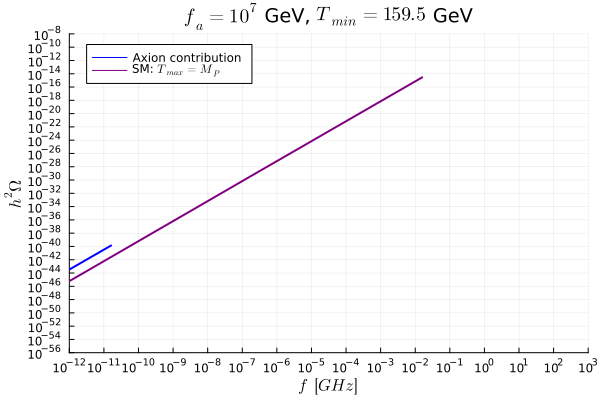

In [54]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-56,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = 10^7$ GeV, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-28:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")

## 1 GeV T_min

In [56]:
ma=0.57e-9                           #[GeV] mass of light neutrinos, Not useful here
fa = 1e7                             # Corresponds to 0.57 eV axion
Tmin= 1                          #[GeV] Freeze-out temperature or where leaves hydrodynamic regime

Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = Omega_GW(farray[i],Tmin,fa,61.75)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)


Tmin_vec = Tmin*ones(size(GWarray))
fa_vec = fa*ones(size(GWarray))
writedlm("/home/ygeoris/Université/SO(10)_project/Data/GW_data/Axion/1GeVTmin_fa1e7.csv",[fa_vec Tmin_vec farray GWarray])

In [57]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-56,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = 10^7$ GeV, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-28:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")

LoadError: BoundsError: attempt to access 0-element Vector{Int64} at index [0]

## f_a = M_P

In [58]:
ma=0.57e-9                           #[GeV] mass of light neutrinos, Not useful here
fa = MP                             
Tmin= 159.5                          #[GeV] Freeze-out temperature or where leaves hydrodynamic regime

Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = Omega_GW(farray[i],Tmin,fa,106.75)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)


Tmin_vec = Tmin*ones(size(GWarray))
fa_vec = fa*ones(size(GWarray))
writedlm("/home/ygeoris/Université/SO(10)_project/Data/GW_data/Axion/EWTmin_faPlanck.csv",[fa_vec Tmin_vec farray GWarray])

In [59]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-56,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = m_{\mathrm{pl}}$, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-28:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")

LoadError: BoundsError: attempt to access 0-element Vector{Int64} at index [0]

# New computation with frequency dependence of Tmin

In [47]:
Tew = 160

function xi(fa) #evaluated at ew temperature but should not change so much in principle...
    alpha = 12*pi/22/nc/abs(log(2*pi*Tew/Lambda))  #No absolute value in principle, just in the meantime to be sure width  if positive
    return kappa*nc^2*(nc^2-1)*alpha^5/fa^2
end

function Omega_GW(f,fa)
    w = 2*pi*f/T0*(g_Tmax/g_Tfin)^(1/3) #keep same number of dof even if Tmin is typically much lower than Tmax
    #if w<Gamma(Tmin,fa) #sqrt(356.82) = sqrt(T0) since change scaling
    return sqrt(356.82)*4.03e-12*f^(5/2)*(g_Tmax/106.75)^(-5/6)*(2*pi^2/225*((g_Tmax/g_Tfin)^(-1/3)/2/pi/xi(fa))^(1/2))*(1/MP*sqrt(8*pi)) #sqrt(8*pi) because reduced Planck mass in Carlos' paper...
    #else
    #    return 0
    #end
end

Omega_GW (generic function with 1 method)

In [53]:
ma=0.57e-9                           #[GeV] mass of light neutrinos, Not useful here
fa = MP                             # Corresponds to 0.57 eV axion
Tmin= 159.5                          #[GeV] Freeze-out temperature or where leaves hydrodynamic regime

Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = Omega_GW(farray[i],fa)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)


Tmin_vec = Tmin*ones(size(GWarray))
fa_vec = fa*ones(size(GWarray))
writedlm("/home/ygeoris/Université/SO(10)_project/Data/GW_data/Axion/EWTmin_faPlanck.csv",[fa_vec Tmin_vec farray GWarray])

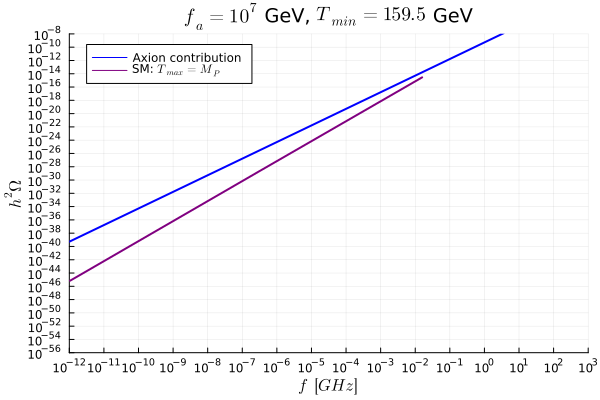

In [49]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-56,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = 10^7$ GeV, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-28:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")

# New computation using Juraj's method

In [6]:
"""
function Denominator(T,khat,fa) #not the HNL one but the graviton one so should not be integrated over...
    E = abs(khat)   
    #if Gamma(T,fa)>khat*T
    #    return Gamma(T,fa)  #here different because we don't integrate over it, just to plug in directly in etahat
    #else
    #    return 4*T^2*khat^2/Gamma(T,fa) #factor of 4 because 2Gamma/(k^2+4Gamma^2) is the real formula
    #end
    return (Gamma(T,fa)^2+4*T^2*khat^2)/Gamma(T,fa)
end


function eta(T,khat,fa)
    return 2*pi^2/225*T/Denominator(T,khat,fa)
end
"""

function alpha(T)
    return 12*pi/22/nc/abs(log(2*pi*T/Lambda))
end

function Gamma(T,fa)  
    return kappa*nc^3*(nc^2-1)*alpha(T)^5*T^3/fa^2
end


function eta(T,khat,fa)  #Pi(k) given by formula (39) divided by 8T^4 basically
    return pi^2/225*T*5*Gamma(T,fa)/(khat^2*T^2+10*Gamma(T,fa)^2)
end

eta (generic function with 1 method)

In [7]:
Gamma(MP,1e19)

1.4958389318216711e12

In [10]:
Tew = 160

###### Omega GW

function xi(fa) #evaluated at ew temperature but should not change so much in principle...
    return kappa*nc^3*(nc^2-1)*alpha(T)^5/fa^2
end

function Omega_GW(f,fa,Tmax,Tmin)
    function diff_rate(x)
        varchange = x*(Tmax-Tmin)+Tmin
        eta(varchange,2*pi*f/T0*(g_Tmax/g_Tfin)^(1/3),fa)*(Tmax-Tmin) 
    end
    integrated_result = vegas((x,f) -> f[1] = diff_rate(x[1]),atol=0,rtol=1e-7)[1][1]
    return 4.03e-12*f^3*(g_Tmax/106.75)^(-5/6)*(1/MP*sqrt(8*pi))*integrated_result #sqrt(8*pi) because reduced Planck mass in Carlos' paper...
end

Omega_GW (generic function with 1 method)

In [11]:
Omega_GW(1e-9,MP,MP,1)

1.4721168794104097e-31

In [15]:
ma=0.57e-9                           #[GeV] mass of light neutrinos, Not useful here
fa = MP                             # Corresponds to 0.57 eV axion
Tmin= 159.5                          #[GeV] Freeze-out temperature or where leaves hydrodynamic regime

Size=200
farray = exp10.(LinRange(-12,3,Size))
GWarray = zeros(Size)
for i in 1:Size
    GWarray[i] = Omega_GW(farray[i],fa,MP,0)
end

x = findall(GWarray.>0)
y = findall(GWarray.<=0)


Tmin_vec = Tmin*ones(size(GWarray))
fa_vec = fa*ones(size(GWarray))
writedlm("/home/ygeoris/Université/SO(10)_project/Data/GW_data/Axion/TmaxPlanck_faPlanck_new.csv",[fa_vec Tmin_vec farray GWarray])

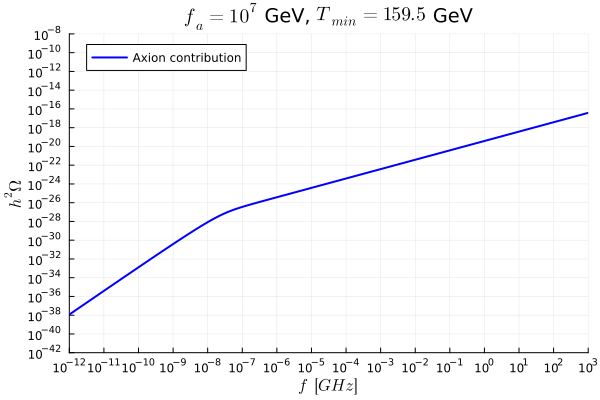

In [16]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-42,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = 10^7$ GeV, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
#p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-38:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")

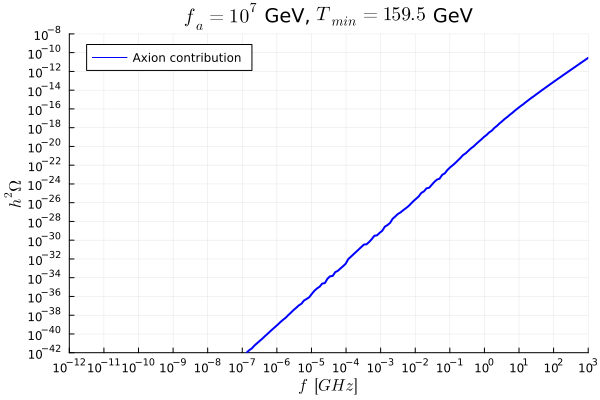

In [195]:
TamaritHydro = readdlm("/home/ygeoris/Université/SO(10)_project/Data/Experimental_lines/Tamarit_Tmax=MP_Hydrodynamic.csv")


p=plot(xlim=(1e-12,1e3),ylim=(1e-42,1e-8),xaxis=:log,yaxis=:log,legend=:topleft, title=L"$f_a = 10^7$ GeV, $T_{\rm{min}}=159.5$ GeV",titlefontsize=13)
p = plot!(farray[1:last(x)],GWarray[1:last(x)],lw=2,color=:blue,label="Axion contribution",ylabel=L"h^2 \Omega",xlabel=L"f~~ \rm{[GHz]}")
#p = plot!(TamaritHydro[1:3,1]/1e9,TamaritHydro[1:3,2],lw=2,color=:purple,label=L"SM: $T_{\rm{max}}=M_P$")
x_ticks=exp10.(-12:3)
y_ticks=exp10.(2*(-38:-3))
xticks!(x_ticks)
yticks!(y_ticks)
#savefig(p,"/home/ygeoris/Université/SO(10)_project/Plots/Hydro_ALP.pdf")